In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import numpy as np
from theano import theano, tensor as tt
from collections import Counter

pm.set_tt_rng(42)
np.random.seed(42)


C:\Users\ASUS\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\ASUS\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
pm.NormalizingFlow


pymc3.variational.approximations.NormalizingFlow

In [3]:
pm.NFVI


pymc3.variational.inference.NFVI

In [4]:
with pm.Model() as dummy:

    N = pm.Normal('N', shape=(100,))


In [5]:
N

N

In [9]:
pm.NormalizingFlow('scale-loc', model=dummy)


In [10]:
pm.NormalizingFlow('scale-hh*100-loc', model=dummy)


In [11]:
pm.NormalizingFlow('scale-hh*100-loc', model=dummy)


In [12]:
pm.NormalizingFlow('scale-hh*10-loc', model=dummy)


In [13]:
pm.NormalizingFlow('scale-hh*10-loc', model=dummy, jitter=.001) # LowRank


In [14]:
def w1(z):
    return tt.sin(2.*np.pi*z[0]/4.)
def w2(z):
    return 3.*tt.exp(-.5*(((z[0]-1.)/.6))**2)
def w3(z):
    return 3.*(1+tt.exp(-(z[0]-1.)/.3))**-1

def pot1(z):
    z = z.T
    return .5*((z.norm(2, axis=0)-2.)/.4)**2 - tt.log(tt.exp(-.5*((z[0]-2.)/.6)**2) +
                                                      tt.exp(-.5*((z[0]+2.)/.6)**2))
def pot2(z):
    z = z.T
    return .5*((z[1]-w1(z))/.4)**2 + 0.1*tt.abs_(z[0])

def pot3(z):
    z = z.T
    return -tt.log(tt.exp(-.5*((z[1]-w1(z))/.35)**2) +
                   tt.exp(-.5*((z[1]-w1(z)+w2(z))/.35)**2)) + 0.1*tt.abs_(z[0])

def pot4(z):
    z = z.T
    return -tt.log(tt.exp(-.5*((z[1]-w1(z))/.4)**2) +
                   tt.exp(-.5*((z[1]-w1(z)+w3(z))/.35)**2)) + 0.1*tt.abs_(z[0])

z = tt.matrix('z')
z.tag.test_value = pm.floatX([[0., 0.]])
pot1f = theano.function([z], pot1(z))
pot2f = theano.function([z], pot2(z))
pot3f = theano.function([z], pot3(z))
pot4f = theano.function([z], pot4(z))


In [15]:
def contour_pot(potf, ax=None, title=None, xlim=5, ylim=5):
    grid = pm.floatX(np.mgrid[-xlim:xlim:100j,-ylim:ylim:100j])
    grid_2d = grid.reshape(2, -1).T
    cmap = plt.get_cmap('inferno')
    if ax is None:
        _, ax = plt.subplots(figsize=(12, 9))
    pdf1e = np.exp(-potf(grid_2d))
    contour = ax.contourf(grid[0], grid[1], pdf1e.reshape(100, 100), cmap=cmap)
    if title is not None:
        ax.set_title(title, fontsize=16)
    return ax


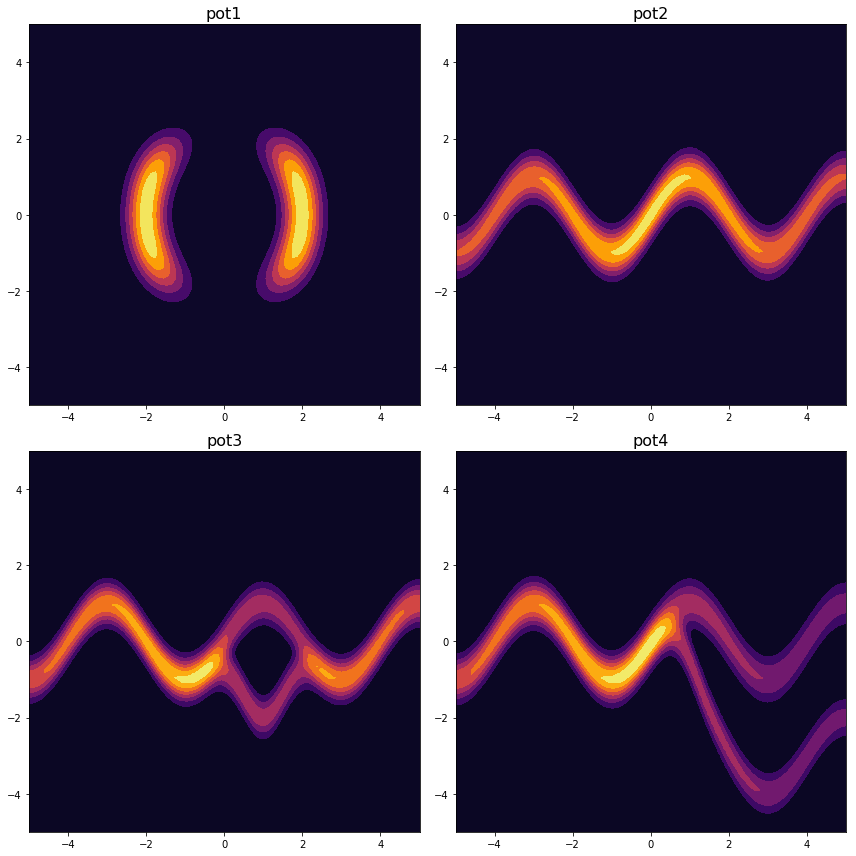

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax = ax.flatten()
contour_pot(pot1f, ax[0], 'pot1', );
contour_pot(pot2f, ax[1], 'pot2');
contour_pot(pot3f, ax[2], 'pot3');
contour_pot(pot4f, ax[3], 'pot4');
fig.tight_layout()


In [17]:
def _contour_pot(potf, ax=None, title=None, xlim=5, ylim=5):
    grid = pm.floatX(np.mgrid[-xlim:xlim:100j,-ylim:ylim:100j])
    grid_2d = grid.reshape(2, -1).T
    #cmap = plt.get_cmap('inferno')
    if ax is None:
        _, ax = plt.subplots(figsize=(12, 9))
    pdf1e = np.exp(-potf(grid_2d))
    #contour = ax.contourf(grid[0], grid[1], pdf1e.reshape(100, 100), cmap=cmap)
    contour = ax.contourf(grid[0], grid[1], pdf1e.reshape(100, 100))
    if title is not None:
        ax.set_title(title, fontsize=16)
    return ax


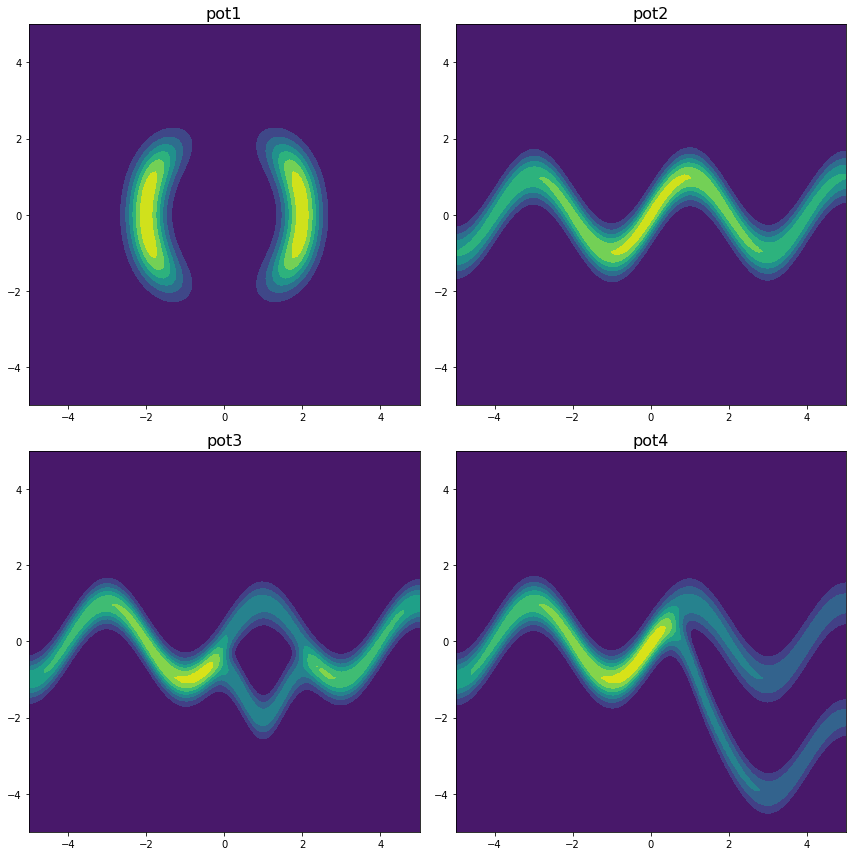

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax = ax.flatten()
_contour_pot(pot1f, ax[0], 'pot1', );
_contour_pot(pot2f, ax[1], 'pot2');
_contour_pot(pot3f, ax[2], 'pot3');
_contour_pot(pot4f, ax[3], 'pot4');
fig.tight_layout()


In [19]:
from pymc3.distributions.dist_math import bound
def cust_logp(z):
    #return bound(-pot1(z), z>-5, z<5)
    return -pot1(z)

with pm.Model() as pot1m:
    pm.DensityDist('pot1', logp=cust_logp, shape=(2,))


In [21]:
pm.set_tt_rng(42)
np.random.seed(42)
with pot1m:
    trace = pm.sample(1000, init='auto', cores=1, start=[dict(pot1=np.array([-2, 0])),
                                                         dict(pot1=np.array([2, 0]))])


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [pot1]
100%|████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:00<00:00, 1961.03it/s]
There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.234618889000021, but should be close to 0.8. Try to increase the number of tuning steps.
There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5569984229628714, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


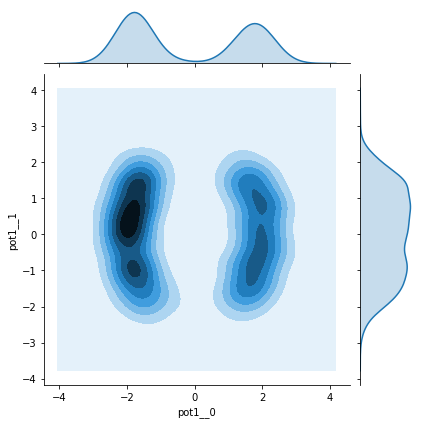

In [22]:
dftrace = pm.trace_to_dataframe(trace)
sns.jointplot(dftrace.iloc[:, 0], dftrace.iloc[:, 1], kind='kde')


In [24]:
pm.set_tt_rng(42)
np.random.seed(42)
with pot1m:
    trace = pm.sample(1000, init='auto', cores=1, chains=1, start=[dict(pot1=np.array([2, 0]))])


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [pot1]
100%|████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:00<00:00, 2086.21it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


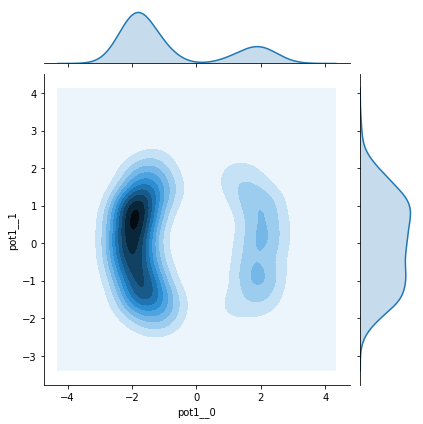

In [25]:
dftrace = pm.trace_to_dataframe(trace)
sns.jointplot(dftrace.iloc[:, 0], dftrace.iloc[:, 1], kind='kde')


In [26]:
pm.set_tt_rng(42)
np.random.seed(42)
with pot1m:
    trace = pm.sample(10000, init='auto', cores=1, chains=1, start=[dict(pot1=np.array([2, 0]))])


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [pot1]
100%|██████████████████████████████████████████████████████████████████████████| 10500/10500 [00:04<00:00, 2155.47it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


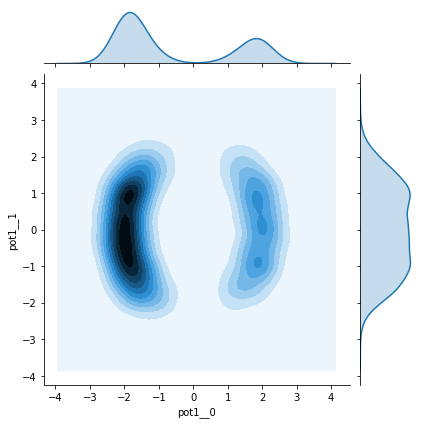

In [27]:
dftrace = pm.trace_to_dataframe(trace)
sns.jointplot(dftrace.iloc[:, 0], dftrace.iloc[:, 1], kind='kde')


In [28]:
pm.set_tt_rng(42)
np.random.seed(42)
with pot1m:
    trace = pm.sample(100000, init='auto', cores=1, chains=1, start=[dict(pot1=np.array([2, 0]))])


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [pot1]
100%|████████████████████████████████████████████████████████████████████████| 100500/100500 [00:47<00:00, 2123.81it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


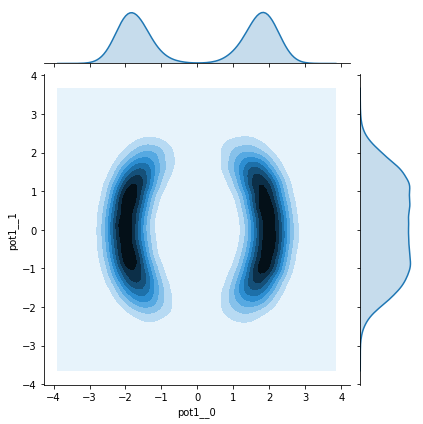

In [29]:
dftrace = pm.trace_to_dataframe(trace)
sns.jointplot(dftrace.iloc[:, 0], dftrace.iloc[:, 1], kind='kde')


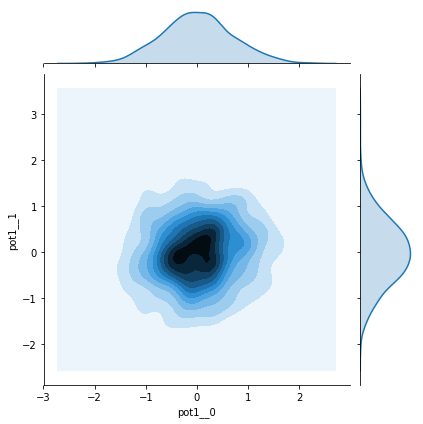

In [54]:
with pot1m:
    inference = pm.ADVI()

## Plotting starting distribution
dftrace = pm.trace_to_dataframe(inference.approx.sample(1000))
sns.jointplot(dftrace.iloc[:, 0], dftrace.iloc[:, 1], kind='kde');


Average Loss = 1.5136:  48%|████████████████████████▍                          | 14388/30000 [00:02<00:02, 5696.87it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 1.9452: 100%|███████████████████████████████████████████████████| 30000/30000 [00:05<00:00, 5783.98it/s]
Finished [100%]: Average Loss = 1.9486


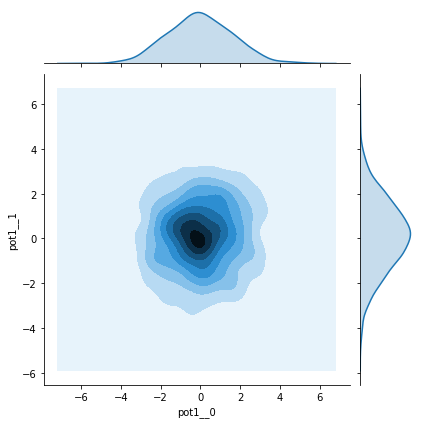

In [55]:
inference.fit(30000, obj_optimizer=pm.adagrad_window(learning_rate=.01))

dftrace = pm.trace_to_dataframe(inference.approx.sample(1000))
sns.jointplot(dftrace.iloc[:, 0], dftrace.iloc[:, 1], kind='kde')


C:\Users\ASUS\Anaconda3\lib\site-packages\theano\tensor\subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


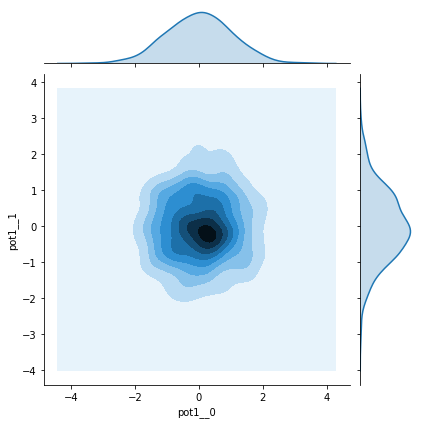

In [56]:
with pot1m:
    inference = pm.FullRankADVI()

## Plotting starting distribution
dftrace = pm.trace_to_dataframe(inference.approx.sample(1000))
sns.jointplot(dftrace.iloc[:, 0], dftrace.iloc[:, 1], kind='kde');


  0%|                                                                                        | 0/30000 [00:00<?, ?it/s]C:\Users\ASUS\Anaconda3\lib\site-packages\theano\tensor\subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
C:\Users\ASUS\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\ASUS\Anaconda3\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidim

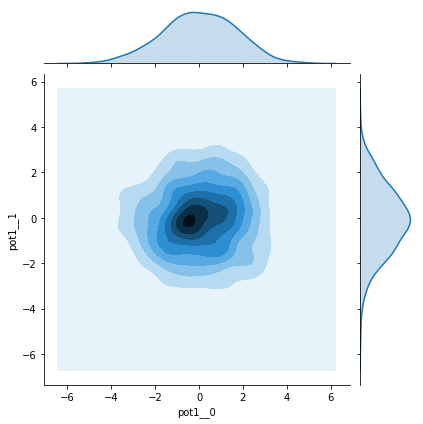

In [57]:
inference.fit(30000, obj_optimizer=pm.adagrad_window(learning_rate=.01))

dftrace = pm.trace_to_dataframe(inference.approx.sample(1000))
sns.jointplot(dftrace.iloc[:, 0], dftrace.iloc[:, 1], kind='kde')


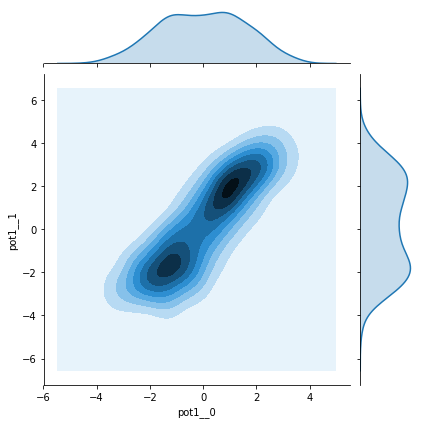

In [35]:
with pot1m:
    inference = pm.NFVI('planar*2', jitter=1)

## Plotting starting distribution
dftrace = pm.trace_to_dataframe(inference.approx.sample(1000))
sns.jointplot(dftrace.iloc[:, 0], dftrace.iloc[:, 1], kind='kde');


In [36]:
inference.approx.params


[b, u, w, b, u, w]

In [37]:
inference.objective(nmc=None)


Elemwise{mul,no_inplace}.0

In [38]:
with theano.configparser.change_flags(compute_test_value='off'):
    grads = tt.grad(inference.objective(None), inference.approx.params)
grads


[Elemwise{add,no_inplace}.0,
 Elemwise{add,no_inplace}.0,
 Elemwise{add,no_inplace}.0,
 Elemwise{add,no_inplace}.0,
 Elemwise{add,no_inplace}.0,
 Elemwise{add,no_inplace}.0]

In [39]:
from collections import defaultdict, OrderedDict
from itertools import count

@theano.configparser.change_flags(compute_test_value='off')
def get_tracker(inference):
    numbers = defaultdict(count)
    params = inference.approx.params
    grads = tt.grad(inference.objective(None), params)
    names = ['%s_%d' % (v.name, next(numbers[v.name])) for v in inference.approx.params]
    return pm.callbacks.Tracker(**OrderedDict(
      [(name, v.eval) for name, v in zip(names, params)] + [('grad_' + name, v.eval) for name, v in zip(names, grads)]
    ))

tracker = get_tracker(inference)


In [40]:
tracker.whatchdict


{'b_0': <bound method Variable.eval of b>,
 'u_0': <bound method Variable.eval of u>,
 'w_0': <bound method Variable.eval of w>,
 'b_1': <bound method Variable.eval of b>,
 'u_1': <bound method Variable.eval of u>,
 'w_1': <bound method Variable.eval of w>,
 'grad_b_0': <bound method Variable.eval of Elemwise{add,no_inplace}.0>,
 'grad_u_0': <bound method Variable.eval of Elemwise{add,no_inplace}.0>,
 'grad_w_0': <bound method Variable.eval of Elemwise{add,no_inplace}.0>,
 'grad_b_1': <bound method Variable.eval of Elemwise{add,no_inplace}.0>,
 'grad_u_1': <bound method Variable.eval of Elemwise{add,no_inplace}.0>,
 'grad_w_1': <bound method Variable.eval of Elemwise{add,no_inplace}.0>}

In [41]:
inference.fit(30000, obj_optimizer=pm.adagrad_window(learning_rate=.01), callbacks=[tracker])


Average Loss = -0.91387: 100%|██████████████████████████████████████████████████| 30000/30000 [00:37<00:00, 806.70it/s]
Finished [100%]: Average Loss = -0.90797


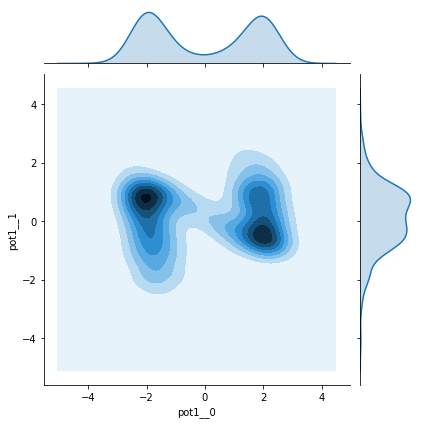

In [42]:
dftrace = pm.trace_to_dataframe(inference.approx.sample(1000))
sns.jointplot(dftrace.iloc[:, 0], dftrace.iloc[:, 1], kind='kde')


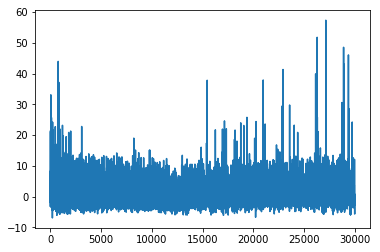

In [43]:
plt.plot(inference.hist);


In [44]:
trackername = ['u_0', 'w_0', 'b_0', 'u_1', 'w_1', 'b_1',
               'grad_u_0', 'grad_w_0', 'grad_b_0', 'grad_u_1', 'grad_w_1', 'grad_b_1']

def plot_tracker_results(tracker):
    fig, ax = plt.subplots(len(tracker.hist)//2, 2, figsize=(16, len(tracker.hist)//2*2.3))
    ax = ax.flatten()
    #names = list(tracker.hist.keys())
    names = trackername
    gnames = names[len(names)//2:]
    names = names[:len(names)//2]
    pairnames = zip(names, gnames)
    def plot_params_and_grads(name, gname):
        i = names.index(name)
        left = ax[i*2]
        right = ax[i*2+1]
        grads = np.asarray(tracker[gname])
        if grads.ndim == 1:
            grads = grads[:, None]
        grads = grads.T
        params = np.asarray(tracker[name])
        if params.ndim == 1:
            params = params[:, None]
        params = params.T
        right.set_title('Gradient of %s' % name)
        left.set_title('Param trace of %s' % name)
        s = params.shape[0]
        for j, (v, g) in enumerate(zip(params, grads)):
            left.plot(v, '-')
            right.plot(g, 'o', alpha=1/s/10)
        left.legend([name + '_%d' % j for j in range(len(names))])
        right.legend([gname + '_%d' % j for j in range(len(names))])

    for vn, gn in pairnames:
        plot_params_and_grads(vn, gn)
    fig.tight_layout()


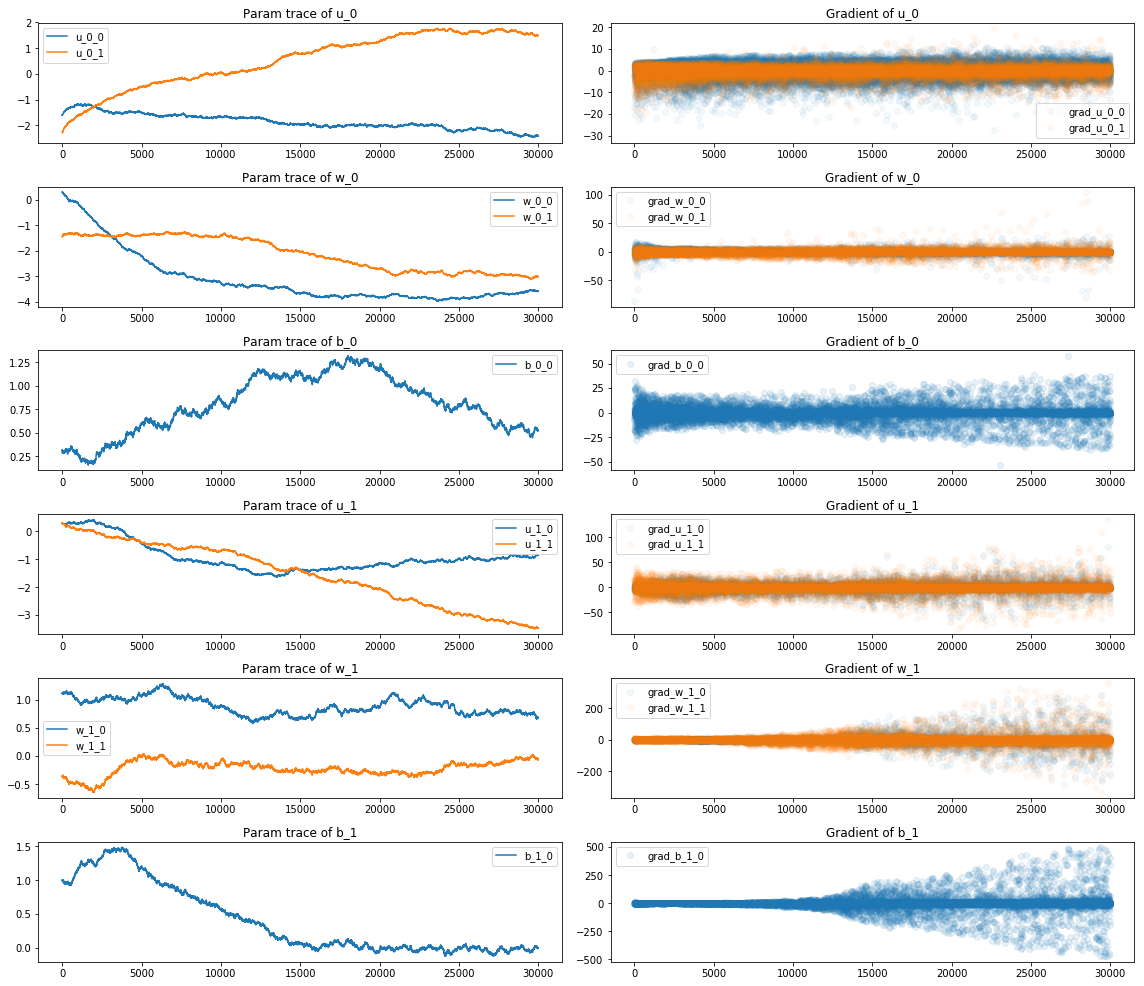

In [45]:
plot_tracker_results(tracker);


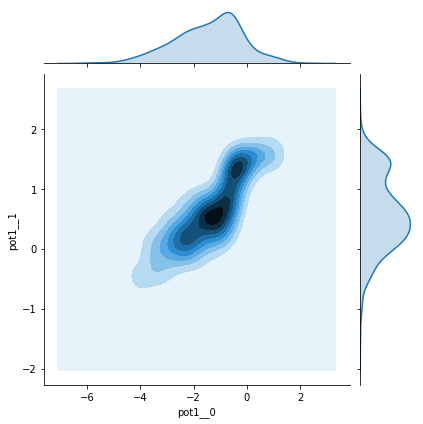

In [46]:
with pot1m:
    inference = pm.NFVI('planar*8', jitter=1.)

dftrace = pm.trace_to_dataframe(inference.approx.sample(1000))
sns.jointplot(dftrace.iloc[:, 0], dftrace.iloc[:, 1], kind='kde');


In [47]:
inference.fit(25000, obj_optimizer=pm.adam(learning_rate=.01), obj_n_mc=100,
              callbacks=[pm.callbacks.CheckParametersConvergence()])


Average Loss = -1.8105: 100%|███████████████████████████████████████████████████| 25000/25000 [00:53<00:00, 467.65it/s]
Finished [100%]: Average Loss = -1.8104


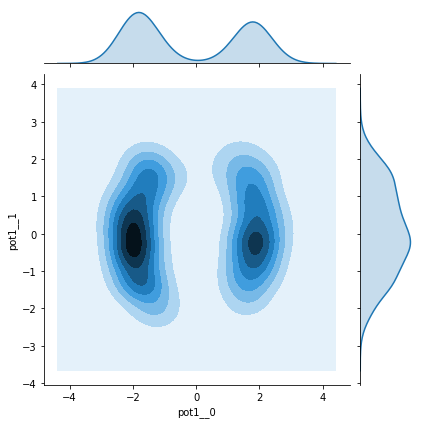

In [48]:
dftrace = pm.trace_to_dataframe(inference.approx.sample(1000))
sns.jointplot(dftrace.iloc[:, 0], dftrace.iloc[:, 1], kind='kde')


In [49]:
def cust_logp(z):
    return -pot4(z)

with pm.Model() as pot_m:
    pm.DensityDist('pot_func', logp=cust_logp, shape=(2,))


In [51]:
with pot_m:
    traceNUTS = pm.sample(3000, tune=1000, target_accept=0.9, cores=1)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [pot_func]
100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 971.61it/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [52]:
formula = 'planar*10'
with pot_m:
    inference = pm.NFVI(formula, jitter=0.1)

inference.fit(25000, obj_optimizer=pm.adam(learning_rate=.01), obj_n_mc=10)

traceNF = inference.approx.sample(5000)


Average Loss = -2.15: 100%|█████████████████████████████████████████████████████| 25000/25000 [00:28<00:00, 892.36it/s]
Finished [100%]: Average Loss = -2.1494


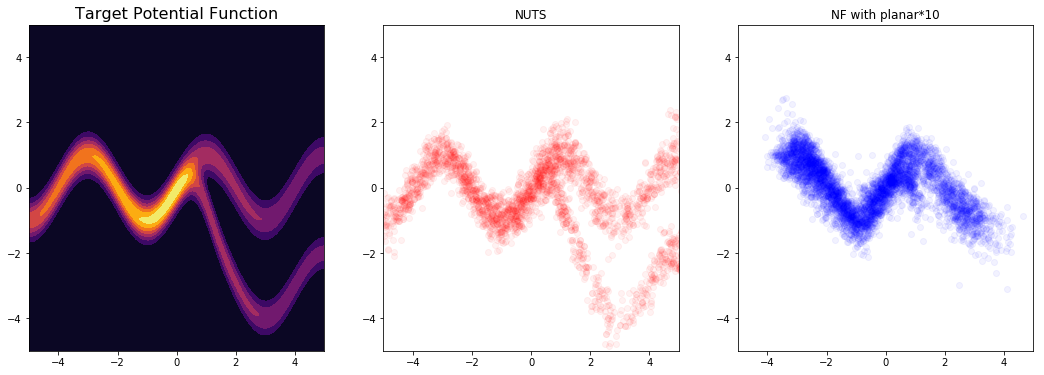

In [53]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
contour_pot(pot4f, ax[0], 'Target Potential Function');

ax[1].scatter(traceNUTS['pot_func'][:,0], traceNUTS['pot_func'][:,1],c='r',alpha=.05)
ax[1].set_xlim(-5,5)
ax[1].set_ylim(-5,5)
ax[1].set_title('NUTS')

ax[2].scatter(traceNF['pot_func'][:,0], traceNF['pot_func'][:,1],c='b',alpha=.05)
ax[2].set_xlim(-5,5)
ax[2].set_ylim(-5,5)
ax[2].set_title('NF with ' + formula);


In [58]:
with pot_m:
    inference = pm.ADVI()

inference.fit(25000, obj_optimizer=pm.adam(learning_rate=.01), obj_n_mc=10)

traceNF = inference.approx.sample(5000)


Average Loss = -1.757: 100%|███████████████████████████████████████████████████| 25000/25000 [00:10<00:00, 2379.87it/s]
Finished [100%]: Average Loss = -1.7556


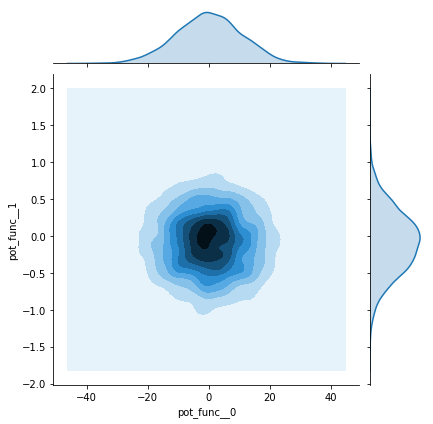

In [59]:
dftrace = pm.trace_to_dataframe(traceNF)
sns.jointplot(dftrace.iloc[:, 0], dftrace.iloc[:, 1], kind='kde')


In [60]:
with pot_m:
    inference = pm.FullRankADVI()

inference.fit(25000, obj_optimizer=pm.adam(learning_rate=.01), obj_n_mc=10)

traceNF = inference.approx.sample(5000)


  0%|                                                                                        | 0/25000 [00:00<?, ?it/s]C:\Users\ASUS\Anaconda3\lib\site-packages\theano\tensor\subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
C:\Users\ASUS\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\ASUS\Anaconda3\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidim

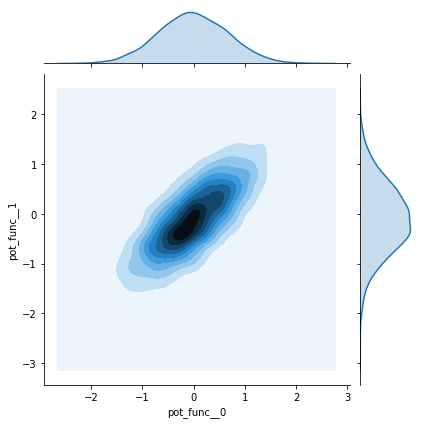

In [61]:
dftrace = pm.trace_to_dataframe(traceNF)
sns.jointplot(dftrace.iloc[:, 0], dftrace.iloc[:, 1], kind='kde')


In [62]:
formula = 'planar*1'
with pot_m:
    inference = pm.NFVI(formula, jitter=0.1)

inference.fit(25000, obj_optimizer=pm.adam(learning_rate=.01), obj_n_mc=10)

traceNF = inference.approx.sample(5000)


Average Loss = -1.2862: 100%|██████████████████████████████████████████████████| 25000/25000 [00:11<00:00, 2144.43it/s]
Finished [100%]: Average Loss = -1.288


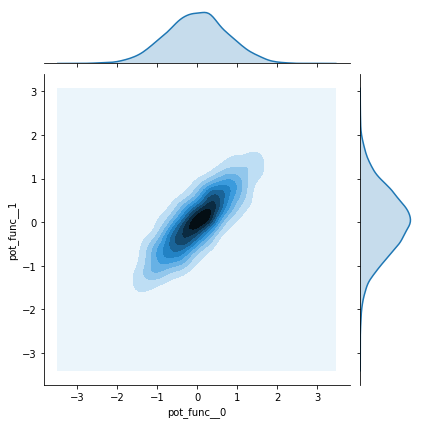

In [63]:
dftrace = pm.trace_to_dataframe(traceNF)
sns.jointplot(dftrace.iloc[:, 0], dftrace.iloc[:, 1], kind='kde')


In [66]:
formula = 'planar*2'
with pot_m:
    inference = pm.NFVI(formula, jitter=0.1)

inference.fit(25000, obj_optimizer=pm.adam(learning_rate=.01), obj_n_mc=10)

traceNF = inference.approx.sample(5000)


Average Loss = -1.696: 100%|███████████████████████████████████████████████████| 25000/25000 [00:12<00:00, 1958.05it/s]
Finished [100%]: Average Loss = -1.6993


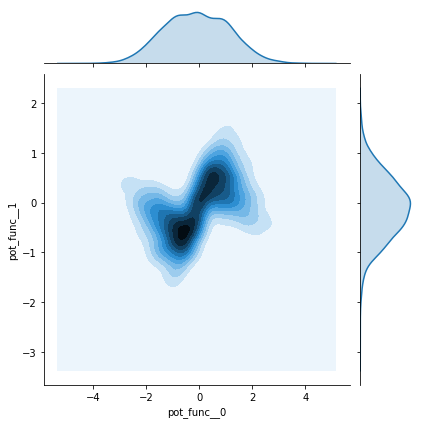

In [67]:
dftrace = pm.trace_to_dataframe(traceNF)
sns.jointplot(dftrace.iloc[:, 0], dftrace.iloc[:, 1], kind='kde')


In [68]:
formula = 'planar*4'
with pot_m:
    inference = pm.NFVI(formula, jitter=0.1)

inference.fit(25000, obj_optimizer=pm.adam(learning_rate=.01), obj_n_mc=10)

traceNF = inference.approx.sample(5000)


Average Loss = -2.1673: 100%|██████████████████████████████████████████████████| 25000/25000 [00:15<00:00, 1582.80it/s]
Finished [100%]: Average Loss = -2.1683


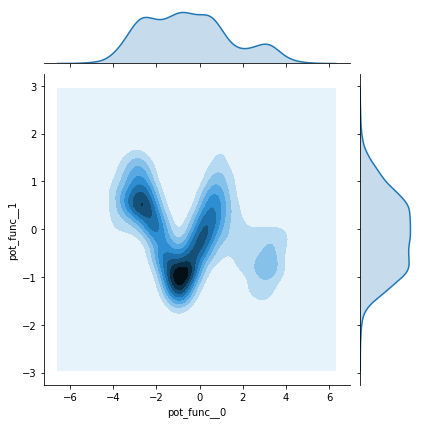

In [69]:
dftrace = pm.trace_to_dataframe(traceNF)
sns.jointplot(dftrace.iloc[:, 0], dftrace.iloc[:, 1], kind='kde')


In [65]:
formula = 'planar*20'
with pot_m:
    inference = pm.NFVI(formula, jitter=0.1)

inference.fit(25000, obj_optimizer=pm.adam(learning_rate=.01), obj_n_mc=10)

traceNF = inference.approx.sample(5000)


KeyboardInterrupt: 

In [ ]:
dftrace = pm.trace_to_dataframe(traceNF)
sns.jointplot(dftrace.iloc[:, 0], dftrace.iloc[:, 1], kind='kde')
